In [1]:
%%html
<style>.container { width:80% !important; }

## <span style='font-family:Georgia'> Objectives
The purpose of this notebook is text mining, aimed at creating a baseline rule-model, which is to be a benchmark of the neural model developed in the later phase of the project.
    
*Author: Elżbieta Jowik, Agata Makarewicz*

In [2]:
import os
import re
import morfeusz2
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(14,8.27), 'axes.facecolor':'white', 'axes.grid' : True, "grid.color": ".9"})

In [3]:
def read_files(dir_path: str, sep: str = ",") -> pd.DataFrame:
    """
    Read the files with timestamps from a given catalog.

    Args:
        dir_path (str): Path to the catalog with the files
        sep (str, optional): Separator used in pd.read_csv() function. Defaults to ",".

    Returns:
        pd.DataFrame: Data from all the files concatenated into one dataframe.
    """
    files = os.listdir(dir_path)
    data = pd.DataFrame([], columns = ['index', 'timestamp_start', 'timestamp_stop', 'word'])
    for file in tqdm(files):
        f = open(os.path.join(dir_path, file), encoding='utf-8', mode='r')
        name = file.split(".")[0]
        df = pd.read_csv(f, header=None, sep=sep, encoding='utf-8')
        df['index'] = name
        if sep != ",":
            df['timestamp_start'] = df.iloc[:,0].str.split(",").str[0].str[1:]
            df['timestamp_stop'] = df.iloc[:,0].str.split(",").str[1].str.split("\)").str[0]
            df['word'] = df.iloc[:,0].str.split("\)+\s").str[1]
            df.drop([0], axis=1, inplace=True)
            df.drop(df.tail(1).index, inplace=True)
        else:
            df['timestamp_start'] = df.iloc[:,0].str[1:]
            df['timestamp_stop'] = df.iloc[:,1].str.split("\)+\s").str[0]
            df['word'] = df.iloc[:,1].str.split("\)+\s").str[1]

            df.drop([0,1], axis=1, inplace=True)
            df.drop(df.tail(1).index, inplace=True)
        data = pd.concat([data, df])
        f.close()
    return data

In [4]:
def calculate_pauses(data: pd.DataFrame) -> pd.DataFrame:
    """
    Generate new features describing pauses between two timestamps.

    Args:
        data (pd.DataFrame): Dataframe with preprocessed timestamp data separated into 'timestamp_start' and 'timestamp_stop' columns.

    Returns:
        pd.DataFrame: Input dataframe with two new features added, describing the pause between the word and after it.
    """
    data.timestamp_start = data.timestamp_start.astype(int)
    data.timestamp_stop = data.timestamp_stop.astype(int)
    data_shifted = pd.concat([data, data.timestamp_start.shift(-1), data.timestamp_stop.shift()], axis=1)
    data_shifted.columns = ['index', 'timestamp_start', 'timestamp_stop', 'word', 'timestamp_start_lead', 'timestamp_stop_lag']
    data_shifted['pause_before'] = data_shifted.timestamp_start - data_shifted.timestamp_stop_lag
    data_shifted['pause_after'] = data_shifted.timestamp_start_lead - data_shifted.timestamp_stop
    data_shifted.drop(['timestamp_start_lead', 'timestamp_stop_lag'], axis=1, inplace=True)
    # to discuss
    data_shifted.pause_before.fillna(data_shifted.timestamp_start, inplace=True)
    data_shifted.pause_after.fillna(0, inplace=True)
    data_shifted.reset_index(drop=True, inplace=True)
    for i, row in data_shifted.iterrows():
        if (i>0) and (data_shifted.loc[i, 'index'] != data_shifted.loc[i-1, 'index']):
            data_shifted.loc[i, 'pause_before'] = data_shifted.loc[i, 'timestamp_start']
            data_shifted.loc[i-1, 'pause_after'] = 0
            
    return data_shifted

In [5]:
def regex_filter(val, regex):
    if val:
        mo = re.search(regex,val)
        if mo:
            return True
        else:
            return False
    else:
        return False

In [6]:
def find_nonalpha(text):
    result = re.findall("[^AaĄąBbCcĆćDdEeĘęFfGgHhIiJjKkLlŁłMmNnŃńOoÓóPpRrSsŚśTtUuVvWwYyZzŹźŻżQqXx]",text)
    return result

In [7]:
def flatten(x):
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result

## <span style='font-family:Georgia'> Data preparation & pauses calculation

In [8]:
# Load data
data_raw = read_files('./train_with_punctuation', sep="\t")
data_calc=calculate_pauses(data_raw).drop(["timestamp_start", "timestamp_stop"], axis=1)

display(Markdown("## Raw data preview"))
display(data_raw)
display(Markdown("## Calculated data preview"))
display(data_calc)

100%|██████████| 793/793 [00:43<00:00, 18.29it/s]


## Raw data preview

,index,timestamp_start,timestamp_stop,word
0,wikinews178430,690,750,we
1,wikinews178430,840,1350,wrocławiu
2,wikinews178430,1650,1920,walkę
3,wikinews178430,2130,2250,ze
4,wikinews178430,2310,2790,szkodnikiem
...,...,...,...,...
158,wikitalks109264,68760,69270,operacji
159,wikitalks109264,69390,69690,łódzkiej
160,wikitalks109264,70320,70320,w
161,wikitalks109264,70380,70530,roku


## Calculated data preview

,index,word,pause_before,pause_after
0,wikinews178430,we,690.0,90.0
1,wikinews178430,wrocławiu,90.0,300.0
2,wikinews178430,walkę,300.0,210.0
3,wikinews178430,ze,210.0,60.0
4,wikinews178430,szkodnikiem,60.0,90.0
...,...,...,...,...
167980,wikitalks109264,operacji,120.0,120.0
167981,wikitalks109264,łódzkiej,120.0,630.0
167982,wikitalks109264,w,630.0,60.0
167983,wikitalks109264,roku,60.0,90.0


### <span style='font-family:Georgia'> Check for noise-causing symbols

In [9]:
target_classes=['.', ',', '?', '!', '-', ':', '...', ' ']

In [10]:
# Check for records with non-character symbols excluded from target classes set
non_characters=np.unique(data_calc['word'].apply(lambda x: find_nonalpha(x)))
symbols_to_drop=list(set(flatten(non_characters))-set(target_classes))
print(f"List of symbols to be dropped: {str(symbols_to_drop)}")

List of symbols to be dropped: ['²', 'ς', 'け', '%', '·', 'в', 'я', '0', '6', 'л', 'ú', 'у', '六', '7', 'β', 'ő', 'ν', 'г', '大', 'à', '9', 'ű', '"', 'č', '€', 'š', 'ß', 'í', 'ニ', 'х', 'ø', 'б', '八', 'е', '1', 'ü', 'ê', 'о', 'ū', 'δ', 'イ', 'ж', '尾', '[', 'ό', 'э', 'к', 'ô', ')', 'ž', 'а', 'ι', 'カ', '8', 'ο', 'й', '(', 'т', 'р', '三', 'м', 'ω', 'ö', 'α', 'ç', 'с', 'д', '蛞', 'á', 'н', '3', 'ã', 'ル', 'é', '馬', 'ä', 'ю', '亀', '2', ']', 'и', 'è', '³', '化', ';', 'φ', 'ř', '蝓', 'ρ', "'", 'ε', 'з', '5', 'п', '五', 'の', '+', '4']


In [11]:
symb_data = data_calc.copy()
symb_data['symbol']=symb_data['word'].apply(lambda x: find_nonalpha(x))
symb_data=symb_data.explode('symbol').reset_index()

symb_data['symbol'].unique()

array([nan, '.', '"', ':', '6', ',', '8', '2', '1', '0', '9', '5', '4',
       '7', '+', '3', '-', "'", '%', '³', '?', ']', '!', ';', 'ö', 'é',
       'í', 'ç', 'ê', 'ä', 'š', 'ž', 'č', 'ő', 'ű', 'è', '(', 'ã', 'à',
       'ú', 'á', '€', 'ø', 'ô', 'ř', 'ü', 'ß', '[', ')', 'α', 'β', 'δ',
       'г', 'о', 'с', 'у', 'д', 'а', 'р', 'т', 'в', 'е', 'н', 'я', 'м',
       'и', 'й', 'к', 'п', 'б', 'ю', 'з', 'л', 'х', 'э', '²', '·', 'φ',
       'ニ', '尾', 'の', '化', 'け', '三', '大', '亀', '五', 'イ', 'ル', 'カ', '馬',
       '六', '蛞', '蝓', '八', 'ū', 'ό', 'ν', 'ε', 'ι', 'ρ', 'ο', 'ς', 'ω',
       'ж'], dtype=object)

In [12]:
symb_data = symb_data.loc[~symb_data["symbol"].isna()]
symb_data = symb_data[~symb_data["symbol"].isin(symbols_to_drop)]

symb_data["symbol"].unique()

array(['.', ':', ',', '-', '?', '!'], dtype=object)

In [13]:
# target classes balance check
symb_data["symbol"].value_counts()

.    10951
,    10163
-     3185
:      934
?      801
!      134
Name: symbol, dtype: int64

In [14]:
# Some files are missings in the source archives and therefore we have 793 out of 800 files.
# All 3 ellipsis symbols are contained in files that are not included and therefore we are missing all training observations for one of the classes.

### <span style='font-family:Georgia'> Short words inspection

In [15]:
words_to_inspect=[]
for sw in symb_data["word"].values:
    if len(sw)>1 and len(sw)<5 and sw not in words_to_inspect:
        words_to_inspect.append(sw)

In [16]:
print(words_to_inspect)

['ul.', 'al.', 'ok.', 'vat.', 'o.', 'lat.', 'się,', 'tym,', 'to,', '".', '2:', '8:', '5:', 'grą,', 'gry.', 'm.', 'in.', "'80,", 'fsc,', 'pkp,', 'mtv.', 'tvn.', 'sam,', '",', 'l.', 'lat,', 'tvn,', 'zła,', 'tzw.', 'on,', 's.', 'a.', 'lng.', 'tam,', 'm³.', '0,', '36,', '77,', '39,', '245,', '1,', 'sił.', 'pzu.', '3,', 'się.', '55,', 'a,', 'gry,', '184,', '101,', '11:', '4:', 'uci.', '6,', 'csc.', 'go.', '12:', 'ks.', '13:', '14:', '5,', '119,', '16:', 'pl,', 'rok.', 'pln,', 'pln.', 'zł.', 'zł,', '23,', 'n.', 'e.', 'tzn.', 'br.', 'św.', 'km.', 'sb.', 'mu,', 'płd.', 'hui.', 'np.', 'onz.', 'ds.', 'usa.', 'sld.', 'tk,', 'ipn.', 'pan,', 'pęk.', 'dyr.', 'tys.', '13,', 'psl.', 'g.', 'ją,', 'nam,', 'r.', 'sld,', 'w:', '26,', 'nie,', 'km,', 'być.', 'ulg,', '610,', '2,', '4,', 'pkt.', 'w.', 'p.', '10,', 'usa,', 'też,', 'vat,', 'art.', 'ust.', 'tk.', 'się:', 'fm,', 'ue.', '66,', 'pis.', '20:', 'pkp.', 'c.', 'ona,', 'im.', '000,', '40,', '722,', '20,', 'jak:', 'wsi.', 'ke,', 'na:', 'tj.', '9:', '00,'

In [17]:
# Conclusion: There seems to be a need to create a predefined abbreviations dictionary for baseline model

### <span style='font-family:Georgia'> Pauses distributions plots

In [18]:
pd.set_option('mode.chained_assignment', None)

In [19]:
dist_plot_data=symb_data[["index", "symbol", "pause_before", "pause_after"]]
# scalling to seconds
dist_plot_data["pause_before"] = dist_plot_data["pause_before"].div(1000)
dist_plot_data["pause_after"] = dist_plot_data["pause_after"].div(1000)

### <span style='font-family:Georgia'> Pauses before

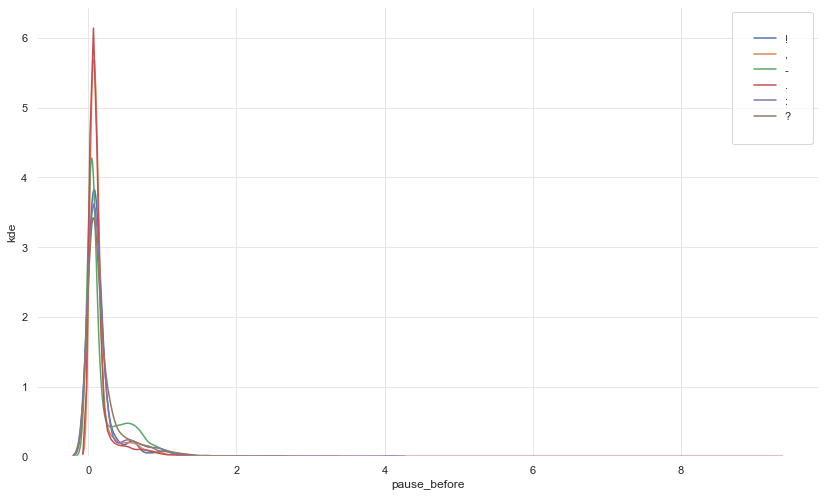

In [20]:
dist_plot_data.groupby('symbol')['pause_before'].apply(lambda x: sns.kdeplot(x, label = x.name))

plt.xlabel('pause_before')
plt.ylabel('kde')
plt.legend(borderpad=2)
plt.show()

### <span style='font-family:Georgia'> Pauses after

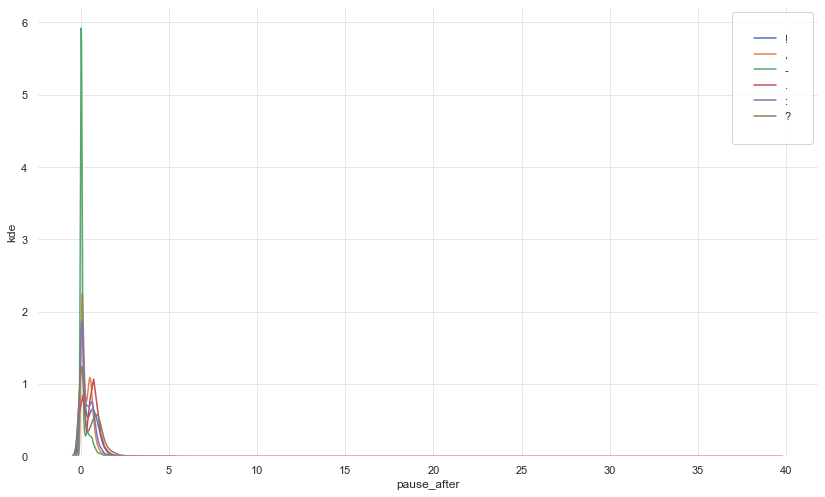

In [21]:
dist_plot_data.groupby('symbol')['pause_after'].apply(lambda x: sns.kdeplot(x, label = x.name))

plt.xlabel('pause_after')
plt.ylabel('kde')
plt.legend(borderpad=2)
plt.show()

### <span style='font-family:Georgia'> Outliers detection

In [22]:
pause_before_outliers=data_calc.loc[data_calc['pause_before']>4500][["index", "pause_before", "pause_after"]].drop_duplicates(subset=["index"])
pause_before_outliers

,index,pause_before,pause_after
8710,wikinews181131,7050.0,4200.0
31668,wikinews185521,4620.0,60.0
37548,wikinews186427,4800.0,120.0
50073,wikinews188651,6630.0,90.0
58975,wikinews190088,4650.0,90.0
60957,wikinews190332,18180.0,30.0
74975,wikinews205726,5220.0,60.0
97491,wikinews228095,39540.0,4740.0
99365,wikinews228304,4950.0,90.0
142195,wikitalks001528,7020.0,510.0


In [23]:
pause_after_outliers=data_calc.loc[data_calc['pause_after']>4500][["index", "pause_before", "pause_after"]].drop_duplicates(subset=["index"])
pause_after_outliers

,index,pause_before,pause_after
8709,wikinews181131,120.0,7050.0
74974,wikinews205726,60.0,5220.0
97490,wikinews228095,600.0,39540.0
142194,wikitalks001528,450.0,7020.0
153419,wikitalks002870,180.0,5310.0


In [24]:
# outliers intersection
pause_before_outliers.merge(pause_after_outliers[["index"]], how="inner", left_on="index", right_on="index")

,index,pause_before,pause_after
0,wikinews181131,7050.0,4200.0
1,wikinews205726,5220.0,60.0
2,wikinews228095,39540.0,4740.0
3,wikitalks001528,7020.0,510.0
4,wikitalks002870,5310.0,9660.0


### <span style='font-family:Georgia'> Pauses distributions plots after all outliers removal

In [25]:
dist_plot_data2 = dist_plot_data[~dist_plot_data["index"].isin(list(pause_before_outliers["index"])+list(pause_after_outliers["index"]))]

### <span style='font-family:Georgia'> Pauses before

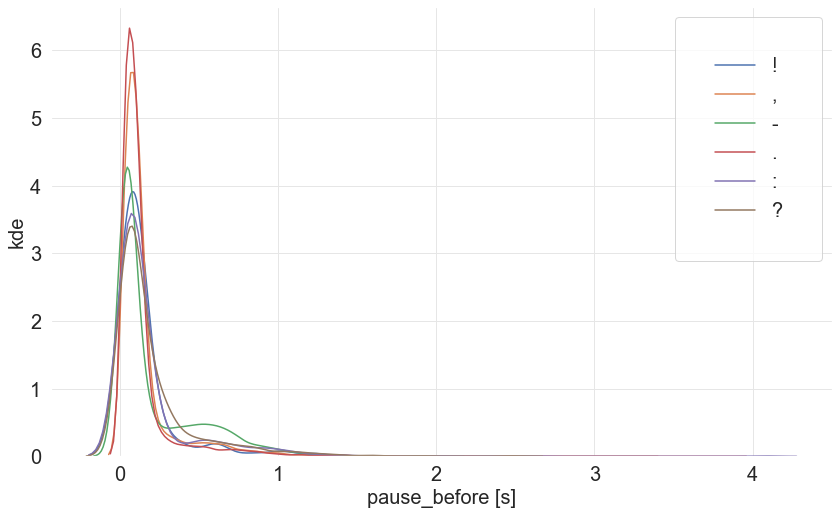

In [30]:
dist_plot_data2.groupby('symbol')['pause_before'].apply(lambda x: sns.kdeplot(x, label = x.name))

plt.xlabel('pause_before [s]', size=20)
plt.ylabel('kde', size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(borderpad=2, fontsize=20)
plt.show()

### <span style='font-family:Georgia'> Pauses after

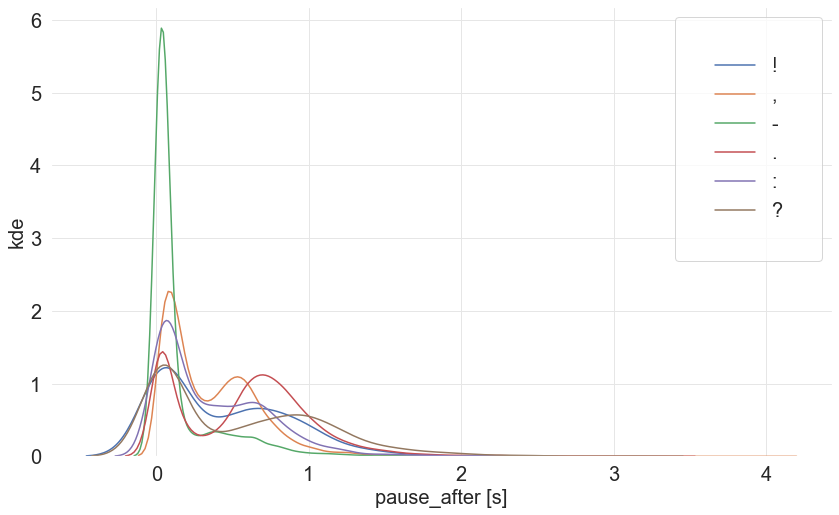

In [32]:
dist_plot_data2.groupby('symbol')['pause_after'].apply(lambda x: sns.kdeplot(x, label = x.name))

plt.xlabel('pause_after [s]', size=20)
plt.ylabel('kde', size=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(borderpad=2, fontsize=20)
plt.show()

In [28]:
# The distributions of pauses after punctuations are more varied than pauses before signs